In [211]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer, precision_recall_curve, auc, f1_score, precision_score, recall_score, classification_report, confusion_matrix, plot_confusion_matrix

In [212]:
credit_card_df = pd.read_csv("creditcard.csv")
credit_card_df.head(5)
print(f"The credit card dataset has {credit_card_df.shape[0]} rows and {credit_card_df.shape[1]} columns")

The credit card dataset has 284807 rows and 31 columns


In [213]:
credit_card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [214]:
#find duplicates 
duplicates = credit_card_df[credit_card_df.duplicated()]
print("Total duplicates in dataset: ", len(duplicates))
credit_card_df.drop_duplicates(keep=False, inplace=True)
print(credit_card_df.shape)

Total duplicates in dataset:  1081
(282953, 31)


In [215]:
#Find nulls 
print("Total nulls in dataset: ", credit_card_df.isnull().sum().sum())
credit_card_df = credit_card_df.dropna() #drop nas

Total nulls in dataset:  0


In [216]:
#Fraud vs Normal transactions 
counts = credit_card_df['Class'].value_counts()
print(f"Total fraud {counts[1]} and total normal transactions {counts[0]}")

Total fraud 460 and total normal transactions 282493


In [217]:
#Numerical stats on Time and Amount 
pd.set_option('precision',3)
credit_card_df[['Time','Amount']].describe()

,Time,Amount
count,282953.000,282953.000
mean,94816.257,88.535
std,47479.632,250.568
min,0.000,0.000
25%,54213.000,5.590
50%,84704.000,22.000
75%,139294.000,77.710
max,172792.000,25691.160


/opt/homebrew/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Distribution of Time Feature'}, xlabel='Time', ylabel='Density'>

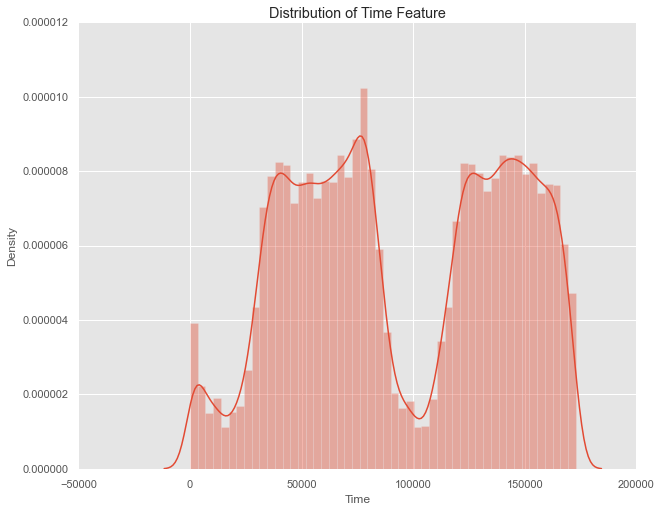

In [218]:
plt.figure(figsize=(10,8))
plt.title('Distribution of Time Feature')
sns.distplot(credit_card_df.Time)

/opt/homebrew/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Distribution of Monetary Value Feature'}, xlabel='Amount', ylabel='Density'>

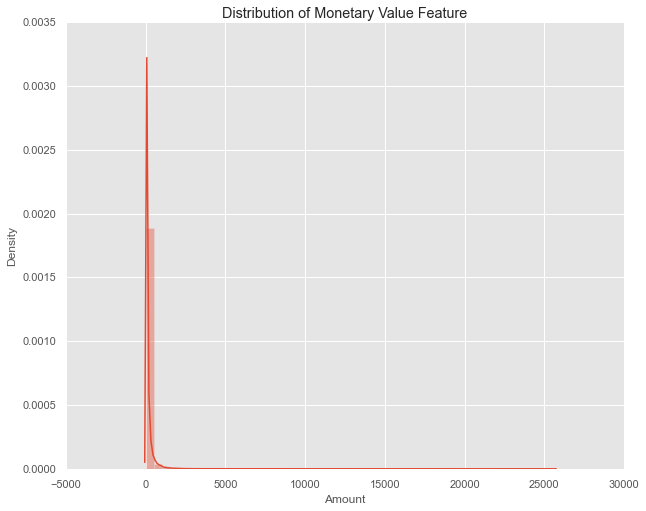

In [219]:
plt.figure(figsize=(10,8))
plt.title('Distribution of Monetary Value Feature')
sns.distplot(credit_card_df.Amount)

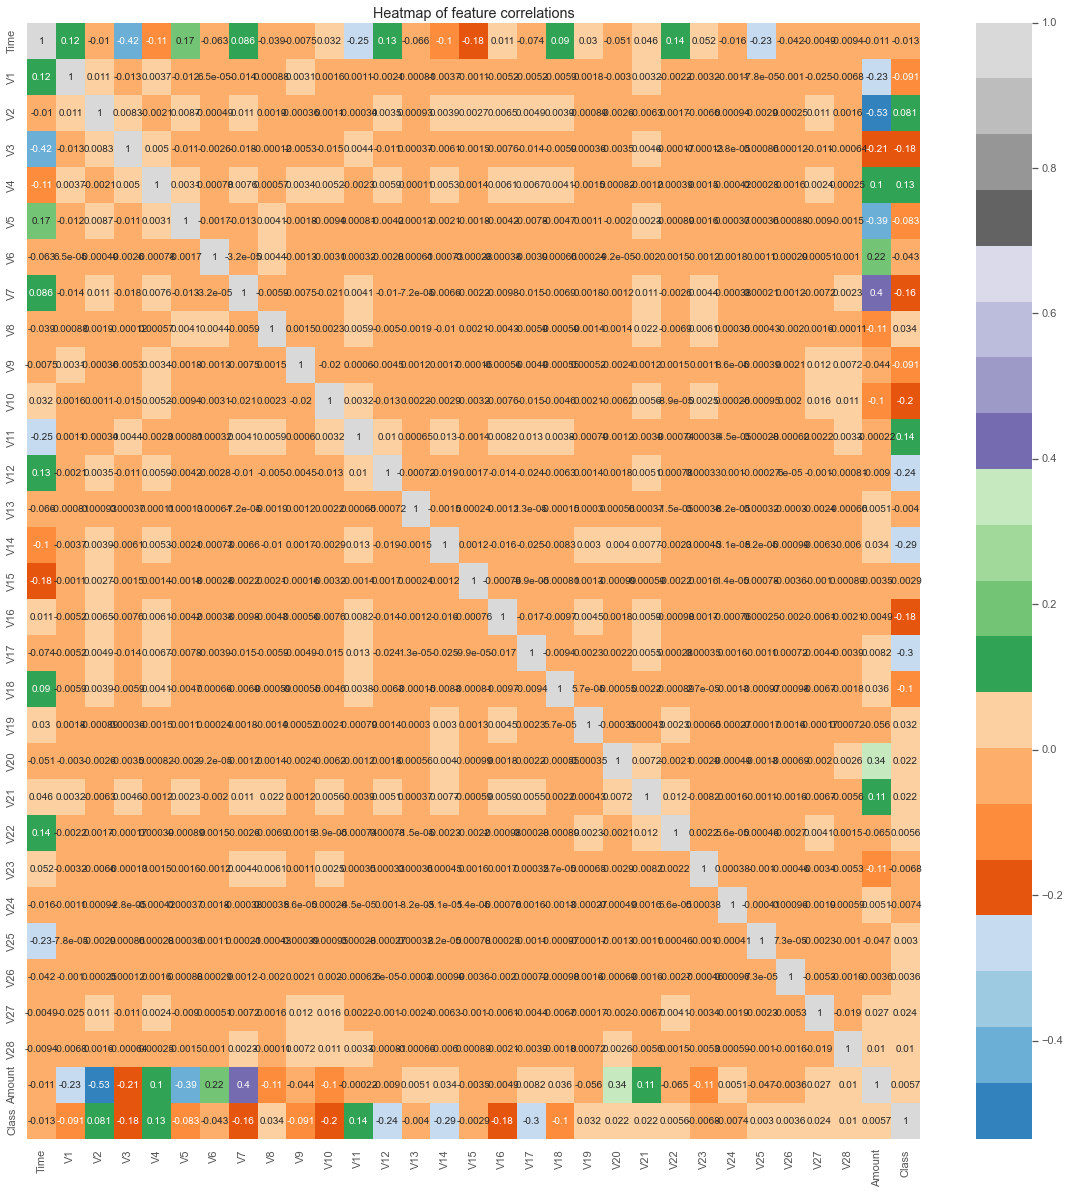

In [220]:
#Check for correlation 
plt.figure(figsize=(20,20))
sns.heatmap(credit_card_df.corr(), annot=True, cmap="tab20c")
plt.title("Heatmap of feature correlations")
plt.show()

### There does not seem to be significant correlation between the features since the values are below +/- 0.5 threshold. V2 & Amount and V7 & Amount appear to have some correlations. 

#### Standardize and Scale data

In [221]:
#shuffle dataset to minimize variance and ensure the model will generalize well to new, unseen data points 
np.random.seed(100)
credit_card_df = credit_card_df.iloc[np.random.permutation(len(credit_card_df))]

In [222]:
def scale_data(column): 
    scaler = StandardScaler()
    scaled = scaler.fit_transform(column)
    scaled_data = pd.Series([item for sublist in scaled.tolist() for item in sublist])
    return scaled_data

In [223]:
credit_card_df['Time'] = scale_data(credit_card_df[['Time']])
credit_card_df['Amount'] = scale_data(credit_card_df[['Amount']])

In [224]:
credit_card_df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
157838,1.131,-0.369,0.352,-0.300,-0.243,1.127,-0.711,0.733,-0.016,1.038,...,-0.348,-0.954,0.410,0.576,-0.450,0.047,0.142,0.084,-0.172,0
77210,-0.483,1.151,0.059,-0.021,1.096,-0.124,-0.393,0.157,-0.003,0.089,...,0.002,-0.015,-0.219,-0.009,0.799,-0.273,-0.010,0.004,-0.286,0
38217,1.225,-0.545,0.017,1.289,-2.537,-0.313,-0.750,0.465,0.020,1.156,...,0.006,-0.144,-0.039,-0.483,-0.204,-0.208,0.082,0.128,0.445,0
54744,-0.402,-0.764,0.931,1.352,-1.266,-0.045,-1.075,1.111,-0.349,-0.350,...,-0.104,-0.379,-0.085,0.460,-0.345,0.616,-0.223,0.083,-0.349,0
148964,0.709,2.117,0.333,-1.767,0.483,0.850,-0.497,0.154,-0.343,1.654,...,-0.539,-1.144,0.271,-0.042,-0.172,0.163,-0.083,-0.040,-0.304,0


In [234]:
credit_card_df = credit_card_df.reset_index(drop=True)
credit_card_df = credit_card_df.dropna()
print(credit_card_df.isnull().sum())
X,y = credit_card_df.drop('Class',axis=1), credit_card_df['Class']
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.2,random_state=42)
print(X.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
dtype: int64


Since we are dealing with an imbalanced dataset, we will use repeated stratified k-fold as our cross validation procedure. We will be using Precision-Recall versus accuracy as our evaluation metric for our models. 

## Model Building

We will focus on tree-ensemble methods as we have a fraud detection datasets and these methods tend to generalize well on such complex dataset. The following machine learning algorithms will be our baseline for testing on the dataset: 
- Decision Trees 
- K-Nearest Neighbors 
- Random Forests 
- XGBoost 

In [235]:
models = {
    'DT' : DecisionTreeClassifier(), 
    'KNN' : KNeighborsClassifier(), 
    'RF' : RandomForestClassifier(), 
    'XGB' : xgb.XGBClassifier(objective='binary:logistic', random_state=0, eval_metric='aucpr',use_label_encoder=False)
}

In [243]:
results = []
for model_name, model in models.items(): 
    cv_results = cross_val_score(model, X_train, y_train, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0), scoring='roc_auc')
    results.append(cv_results)
    print(f"model: {model_name} has {cv_results.mean()} as auc mean and {cv_results.std()} as auc std")


model: DT has 0.8706804955897082 as auc mean and 0.025403278573527442 as auc std
model: KNN has 0.9242252480693575 as auc mean and 0.02142162627088593 as auc std
model: RF has 0.9445423533455628 as auc mean and 0.02007613009875454 as auc std
model: XGB has 0.9711528760773542 as auc mean and 0.015287480762818292 as auc std


In [249]:
print(results)

[array([0.90516044, 0.86460876, 0.87815568, 0.89705985, 0.82858897,
       0.85791882, 0.90520498, 0.87810001, 0.84915918, 0.84919258,
       0.82414617, 0.8985039 , 0.87817795, 0.85596396, 0.89026621]), array([0.93234396, 0.92556162, 0.93905708, 0.94507888, 0.87660144,
       0.88501175, 0.959394  , 0.9255714 , 0.93816641, 0.91083795,
       0.93233132, 0.9052426 , 0.9391296 , 0.91765477, 0.93139596]), array([0.94468018, 0.94428339, 0.9511864 , 0.96479445, 0.90186126,
       0.90980338, 0.9856619 , 0.95815954, 0.94357704, 0.92997253,
       0.93745922, 0.94429392, 0.96507715, 0.94367116, 0.94365377]), array([0.97340362, 0.98065091, 0.97626919, 0.97786389, 0.92739   ,
       0.95348064, 0.98931805, 0.96737244, 0.9845201 , 0.96130466,
       0.98338678, 0.96614941, 0.98819855, 0.96606947, 0.97191543])]


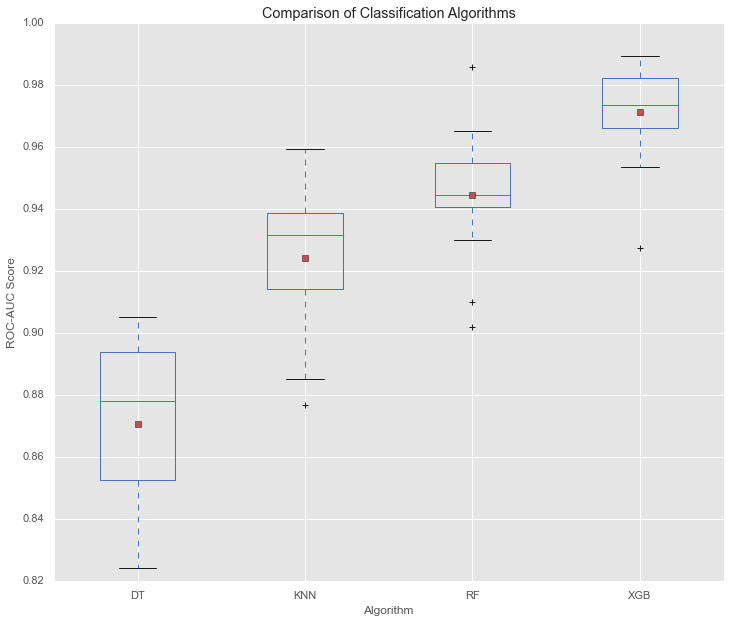

In [254]:
#Compare algorithms 
fig = plt.figure(figsize=(12,10))
plt.title('Comparison of Classification Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('ROC-AUC Score')
plt.boxplot(results, labels = models.keys(),showmeans=True)
plt.show()